# Check for suppression of X-rays

For this, the reference detectors were removed from the lead container and afterwards placed inside the lead container.

Measurement took place on 2020-01-30:

- /Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-01-30.EmittingSpotSize_test.xlsx
- /Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-01-30.EmittingSpotSize_test_lead_around_detectors.xlsx

# Load data from Database

In [76]:
import numpy as np
import pandas as pd
import pymysql
import sqlalchemy as sql
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
sns.set()
import getopt
import sys
import datetime
from scipy.interpolate import interp1d
from NGDataObject import NGDataObject

#*******************************
# CONSTANTS
#*******************************
# connection to database
CREDENTIALS_FILE = '/Users/hkromer/02_PhD/01.github/dash_NG/credentials.pw'
DB = "NG_twofast_DB" # name of the database
HOST = "twofast-RPi3-0"  # database host

# LOOKUP TABLES
LUT_PRESSURE_ION_SOURCE = "/Users/hkromer/02_PhD/01.github/phd/01_neutron_generator_contol/LUT_pressure_ion_source.txt"

In [77]:
DAY = "2020-01-30" # day to extract from the db

In [ ]:
# read password and user to connect to database
credentials = pd.read_csv(CREDENTIALS_FILE, header=0)
user = credentials['username'].values[0]
pw = credentials['password'].values[0]


#*******************************
# GET DATA
#*******************************

# connect to DB
con = NGDataObject(host = HOST, database=DB, user=user, password=pw)

# get dose
query = "SELECT * FROM data_dose WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_dose = con.get_from_database(query=query)

# get HV
query = "SELECT * FROM data_HV WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_hv = con.get_from_database(query=query)
data_hv['HV_current_x100'] = data_hv['HV_current']*100.0

# get pressure
query = "SELECT * FROM data_pressure WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_pressure = con.get_from_database(query=query)

# get reference detectors
query = "SELECT * FROM data_referenceDetectors WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_reference_full = con.get_from_database(query=query)

# get microwave power
query = "SELECT * FROM microwave_generator_power WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_microwave_power_full = con.get_from_database(query=query)

# get microwave frequency
query = "SELECT * FROM microwave_generator_frequency WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_microwave_frequency_full = con.get_from_database(query=query)

In [ ]:
# save to file
data_reference_full['sum_counts'] = data_reference_full['counts_D1'] + data_reference_full['counts_D2'] + data_reference_full['counts_D3'] + data_reference_full['counts_D4'] 

path = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/DATA/x_ray_suppression/'
data_dose.to_csv(f'{path}/2020-02-06_dose.csv')
data_hv.to_csv(f'{path}/2020-02-06_hv.csv')
data_pressure.to_csv(f'{path}/2020-02-06_pressure.csv')
data_reference_full.to_csv(f'{path}/2020-02-06_reference_detectors.csv')
data_microwave_power_full.to_csv(f'{path}/2020-02-06_microwave_power.csv')
data_microwave_frequency_full.to_csv(f'{path}/2020-02-06_microwave_frequency.csv')

In [78]:
path = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/DATA/x_ray_suppression/'
data_dose = pd.read_csv(f'{path}/2020-02-06_dose.csv', index_col=0, parse_dates=True)
data_hv = pd.read_csv(f'{path}/2020-02-06_hv.csv', index_col=0, parse_dates=True)
data_pressure = pd.read_csv(f'{path}/2020-02-06_pressure.csv', index_col=0, parse_dates=True)
data_reference_full = pd.read_csv(f'{path}/2020-02-06_reference_detectors.csv', index_col=0, parse_dates=True)
data_microwave_power_full = pd.read_csv(f'{path}/2020-02-06_microwave_power.csv', index_col=0, parse_dates=True)
data_microwave_frequency_full = pd.read_csv(f'{path}/2020-02-06_microwave_frequency.csv', index_col=0, parse_dates=True)

# Influence on the microwave on the count rate in the detector

## Microwave on: 13:32 until 14:30
## Microwave off: 16:30 until 17:20

Text(0.5, 0, 'Time, 2020-01-30')

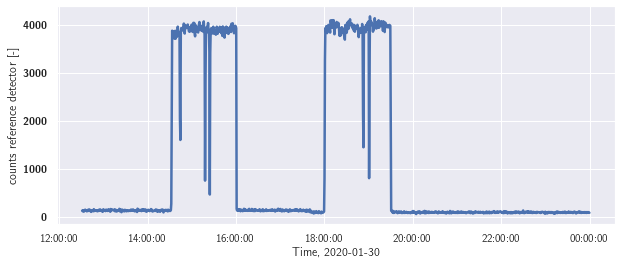

In [79]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_reference_full.index, y='sum_counts', data=data_reference_full, ax=ax)
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))
# ax.set(yscale="log")
ax.set_ylabel('counts reference detector [-]')
ax.set_xlabel(f'Time, {DAY}')

In [80]:
data_microwave_power_full.head()

,FP,RP,power_setpoint,id
time,,,,
2020-01-30 13:31:53.203511,0.0,0.0,200.0,225868
2020-01-30 13:31:53.505523,0.0,0.0,200.0,225869
2020-01-30 13:31:53.798429,0.0,0.0,200.0,225870
2020-01-30 13:31:54.092085,0.0,0.0,200.0,225871
2020-01-30 13:31:54.385087,0.0,0.0,200.0,225872


Text(0.5, 0, 'Time, 2020-01-30')

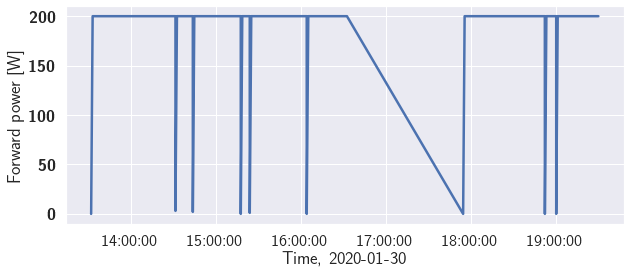

In [81]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_microwave_power_full.index, y='FP', data=data_microwave_power_full, ax=ax)
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))
# ax.set(yscale="log")
ax.set_ylabel('Forward power [W]')
ax.set_xlabel(f'Time, {DAY}')

Text(0.5, 0, 'Time, 2020-01-30')

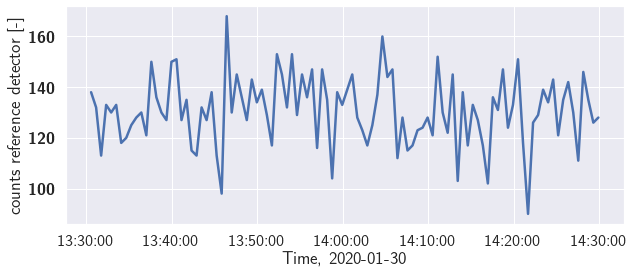

In [82]:
start_mw = '2020-01-30 13:30:00'
end_mw = '2020-01-30 14:30:00'
data_reference_s = data_reference_full.loc[start_mw:end_mw, :]

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_reference_s.index, y='sum_counts', data=data_reference_s, ax=ax)
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))
# ax.set(yscale="log")
ax.set_ylabel('counts reference detector [-]')
ax.set_xlabel(f'Time, {DAY}')

Text(0.5, 0, 'Time, 2020-01-30')

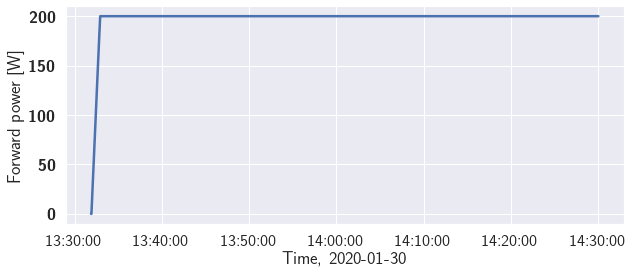

In [83]:
data_microwave_power_s = data_microwave_power_full.loc[start_mw:end_mw, :]
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_microwave_power_s.index, y='FP', data=data_microwave_power_s, ax=ax)
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))
# ax.set(yscale="log")
ax.set_ylabel('Forward power [W]')
ax.set_xlabel(f'Time, {DAY}')

Text(0.5, 0, 'Time, 2020-01-30')

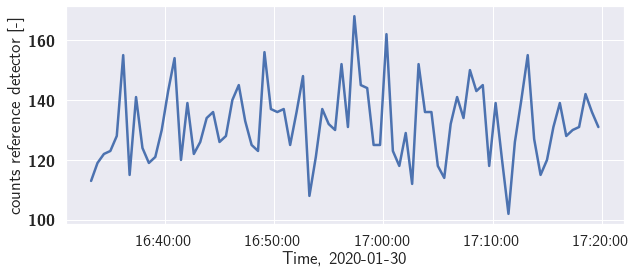

In [84]:
start_no_mw = '2020-01-30 16:33:00'
end_no_mw = '2020-01-30 17:20:00'
data_reference_s = data_reference_full.loc[start_no_mw:end_no_mw, :]

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_reference_s.index, y='sum_counts', data=data_reference_s, ax=ax)
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))
# ax.set(yscale="log")
ax.set_ylabel('counts reference detector [-]')
ax.set_xlabel(f'Time, {DAY}')

In [85]:
data_microwave_power_full.loc[start_no_mw:end_no_mw, :]


,FP,RP,power_setpoint,id
time,,,,


Text(0.5, 0, '30 seconds readout interval')

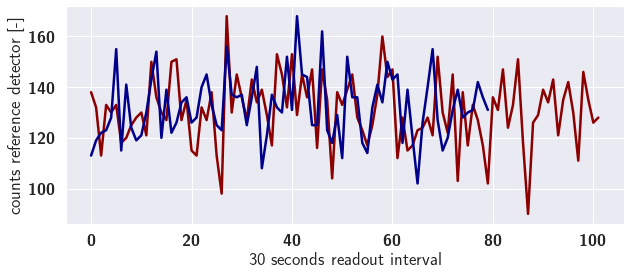

In [86]:
start_mw = '2020-01-30 13:30:00'
end_mw = '2020-01-30 14:30:00'

start_no_mw = '2020-01-30 16:33:00'
end_no_mw = '2020-01-30 17:20:00'

# counts when on and off
ref_counts_on = data_reference_full.loc[start_mw:end_mw, :]
ref_counts_off = data_reference_full.loc[start_no_mw:end_no_mw, :]

ref_counts_on = ref_counts_on.reset_index()
ref_counts_off = ref_counts_off.reset_index()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=ref_counts_on.index, y='sum_counts', data=ref_counts_on, ax=ax, color='darkred')
sns.lineplot(x=ref_counts_off.index, y='sum_counts', data=ref_counts_off, ax=ax, color='darkblue')

# ax.set(yscale="log")
ax.set_ylabel('counts reference detector [-]')
ax.set_xlabel(f'30 seconds readout interval')

In [87]:
# Combine reference detector counts into one dataframe
ref_counts_on['label'] = 'On'
ref_counts_off['label'] = 'Off'

ref_counts_combined = ref_counts_on.append(ref_counts_off).reset_index()
ref_counts_combined

,index,time,id,ard_time,counts_D1,counts_D2,counts_D3,counts_D4,sum_counts,label
0,0,2020-01-30 13:30:32.275054,1643,34386.0,39.0,33.0,32.0,34.0,138.0,On
1,1,2020-01-30 13:31:07.526090,1644,34386.0,36.0,39.0,35.0,22.0,132.0,On
2,2,2020-01-30 13:31:42.777411,1645,34386.0,23.0,37.0,25.0,28.0,113.0,On
3,3,2020-01-30 13:32:18.027545,1646,34386.0,31.0,32.0,30.0,40.0,133.0,On
4,4,2020-01-30 13:32:53.278804,1647,34386.0,37.0,39.0,24.0,30.0,130.0,On
...,...,...,...,...,...,...,...,...,...,...
177,75,2020-01-30 17:17:19.729149,2029,34386.0,32.0,36.0,30.0,32.0,130.0,Off
178,76,2020-01-30 17:17:54.980403,2030,34386.0,30.0,39.0,31.0,31.0,131.0,Off
179,77,2020-01-30 17:18:30.231973,2031,34386.0,28.0,48.0,25.0,41.0,142.0,Off
180,78,2020-01-30 17:19:05.482282,2032,34386.0,21.0,40.0,38.0,37.0,136.0,Off


Text(0.5, 0, 'Microwave')

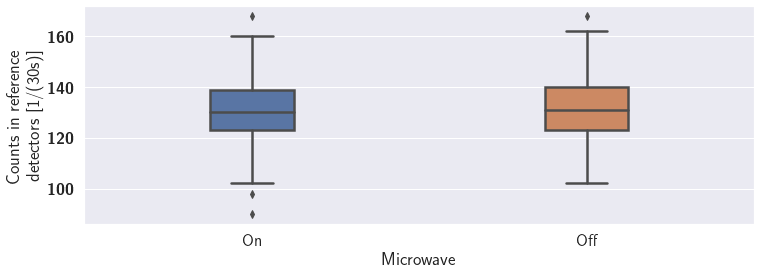

In [88]:

fig, ax = plt.subplots(figsize=(12,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.boxplot(x='label', y='sum_counts', data=ref_counts_combined, ax=ax, width=0.25)


# plt.title('Reference detectors')
# ax.set(yscale="log")
ax.set_ylabel('Counts in reference \n detectors [1/(30s)]')
ax.set_xlabel(f'Microwave')

In [89]:
print(f'Data points (30 sec intervals) when MW on: {ref_counts_on.shape[0]}, when MW off: {ref_counts_off.shape[0]}')
print(f'Mean ON, OFF: {ref_counts_on.sum_counts.mean()}, {ref_counts_off.sum_counts.mean()}')
print(f'Std ON, OFF: {ref_counts_on.sum_counts.std()}, {ref_counts_off.sum_counts.std()}')

Data points (30 sec intervals) when MW on: 102, when MW off: 80
Mean ON, OFF: 130.76470588235293, 132.15
Std ON, OFF: 13.525316541079574, 12.803381673545509


Text(0.5, 0, 'Counts')

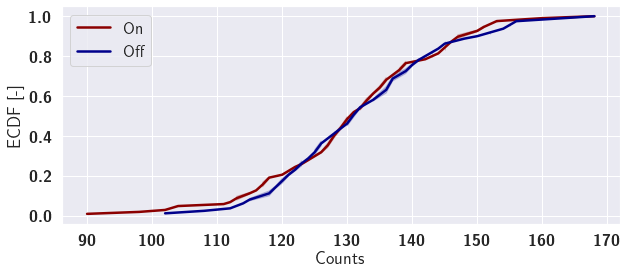

In [90]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

x_ecdf_mw_on, y_ecdf_mw_on = ecdf(ref_counts_on['sum_counts'])
x_ecdf_mw_off, y_ecdf_mw_off = ecdf(ref_counts_off['sum_counts'])

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=x_ecdf_mw_on, y=y_ecdf_mw_on, ax=ax, color='darkred', label='On')
sns.lineplot(x=x_ecdf_mw_off, y=y_ecdf_mw_off, ax=ax, color='darkblue', label='Off')

# ax.set(yscale="log")
ax.set_ylabel('ECDF [-]')
ax.set_xlabel(f'Counts')

# No lead around the detectors

# From 13:30 until 16:35


In [91]:
def resample_30_seconds(df, cols, range_start, range_end):
    """
    Takes the a grouped df (grouped by day) and resamples the columns cols in 10s
    OUTPUT:
        - dataframe
    """

    d = {}

    s = pd.date_range(start=range_start, end=range_end, freq='30S')
    df_out = pd.DataFrame(pd.Series(s, name='time')).set_index('time')
    for col in cols:
        d[col] = df[col].resample('30S').mean()

    this_d = pd.DataFrame(d)

    df_out = df_out.merge(this_d, left_on=df_out.index, right_on=this_d.index, how='outer')
    df_out = df_out.set_index('key_0')
    
    return df_out

In [92]:
start = '2020-01-30 14:35:00'
end = '2020-01-30 15:59:00'

### Plot HV, dose, microwave power, pressure, reference counts

In [93]:
data_hv_s = data_hv.loc[start:end, :]
data_dose_s = data_dose.loc[start:end, :]
data_pressure_s = data_pressure.loc[start:end, :]
data_reference_s = data_reference_full.loc[start:end, :]
data_microwave_frequency_s = data_microwave_frequency_full.loc[start:end, :]
data_microwave_power_s = data_microwave_power_full.loc[start:end, :]

In [94]:
data_dose_s.head()

,id,dose,dose_voltage,dose_corrected
time,,,,
2020-01-30 14:35:00.507108,15408486,567.273,1.04,616.289
2020-01-30 14:35:01.506751,15408487,567.273,1.04,616.289
2020-01-30 14:35:02.509855,15408488,556.364,1.02,595.694
2020-01-30 14:35:03.513131,15408489,567.273,1.04,616.289
2020-01-30 14:35:04.517686,15408490,567.273,1.04,616.289


Text(0.5, 0, 'Time, 2020-01-30')

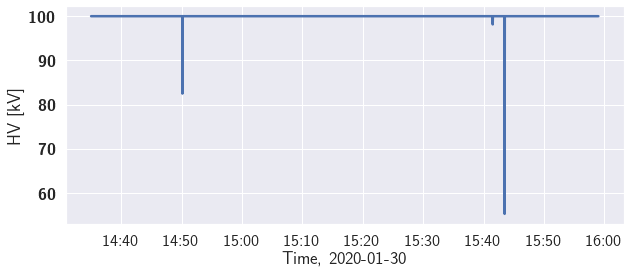

In [95]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv_s.index, y='HV_voltage', data=data_hv_s, ax=ax)
# sns.lineplot(x=data_hv_s_rs.index, y='HV_voltage', data=data_hv_s_rs, ax=ax, color='darkred')
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set(yscale="log")
ax.set_ylabel('HV [kV]')
ax.set_xlabel(f'Time, {DAY}')


In [96]:
# remove outliers
data_dose_s = data_dose_s[data_dose_s['dose_corrected'] > 580]
data_reference_s = data_reference_s[data_reference_s['sum_counts'] > 3600]
data_hv_s = data_hv_s[data_hv_s['HV_voltage'] > 99.5]


# resample the 30 s
data_dose_s_rs = resample_30_seconds(data_dose_s, ['dose_corrected'], start, end)
data_dose_s_rs.index = data_dose_s_rs.index.rename('time')

data_reference_s_rs = resample_30_seconds(data_reference_s, ['sum_counts'], start, end)
data_reference_s_rs.index = data_reference_s_rs.index.rename('time')

data_hv_s_rs = resample_30_seconds(data_hv_s, ['HV_voltage', 'HV_current',], start, end)
data_hv_s_rs.index = data_hv_s_rs.index.rename('time')

In [97]:
data_hv_s_rs

,HV_voltage,HV_current
time,,
2020-01-30 14:35:00,100.0,0.662013
2020-01-30 14:35:30,100.0,0.660400
2020-01-30 14:36:00,100.0,0.660987
2020-01-30 14:36:30,100.0,0.660987
2020-01-30 14:37:00,100.0,0.663920
...,...,...
2020-01-30 15:57:00,100.0,0.671547
2020-01-30 15:57:30,100.0,0.669493
2020-01-30 15:58:00,100.0,0.670373


Text(0.5, 0, 'Time, 2020-01-30')

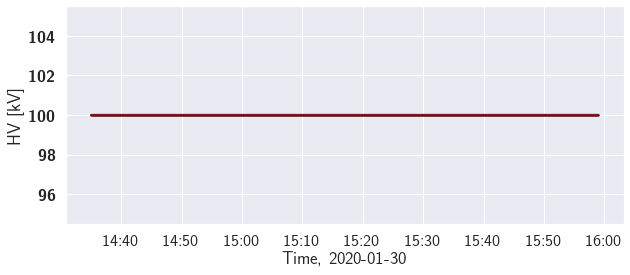

In [98]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv_s.index, y='HV_voltage', data=data_hv_s, ax=ax)
sns.lineplot(x=data_hv_s_rs.index, y='HV_voltage', data=data_hv_s_rs, ax=ax, color='darkred')
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set(yscale="log")
ax.set_ylabel('HV [kV]')
ax.set_xlabel(f'Time, {DAY}')

Text(0.5, 0, 'Time, 2020-01-30')

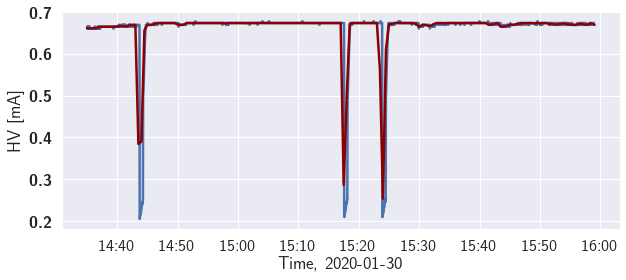

In [99]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv_s.index, y='HV_current', data=data_hv_s, ax=ax)
sns.lineplot(x=data_hv_s_rs.index, y='HV_current', data=data_hv_s_rs, ax=ax, color='darkred')
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set(yscale="log")
ax.set_ylabel('HV [mA]')
ax.set_xlabel(f'Time, {DAY}')

(0, 650)

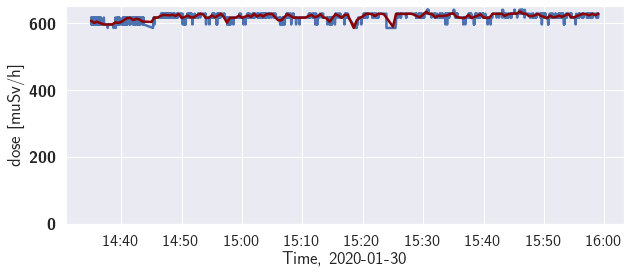

In [100]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_dose_s.index, y='dose_corrected', data=data_dose_s, ax=ax)
sns.lineplot(x=data_dose_s_rs.index, y='dose_corrected', data=data_dose_s_rs, ax=ax, color='darkred')
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set(yscale="log")
ax.set_ylabel('dose [muSv/h]')
ax.set_xlabel(f'Time, {DAY}')
plt.ylim(0,650)

In [101]:
data_reference_s.head()

,id,ard_time,counts_D1,counts_D2,counts_D3,counts_D4,sum_counts
time,,,,,,,
2020-01-30 14:35:09.892012,1753,34386.0,895.0,1185.0,841.0,933.0,3854.0
2020-01-30 14:35:45.147055,1754,34386.0,828.0,1218.0,743.0,1021.0,3810.0
2020-01-30 14:36:20.401718,1755,34386.0,888.0,1180.0,741.0,907.0,3716.0
2020-01-30 14:36:55.656651,1756,34386.0,867.0,1232.0,821.0,906.0,3826.0
2020-01-30 14:37:30.912793,1757,34386.0,880.0,1207.0,855.0,935.0,3877.0


(0, 4500)

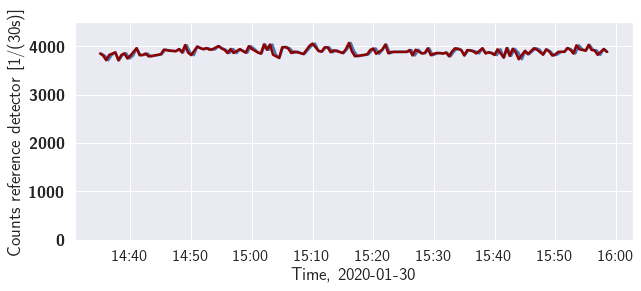

In [102]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_reference_s.index, y='sum_counts', data=data_reference_s, ax=ax)
sns.lineplot(x=data_reference_s_rs.index, y='sum_counts', data=data_reference_s_rs, ax=ax, color='darkred')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set(yscale="log")
ax.set_ylabel('Counts reference detector [1/(30s)]')
ax.set_xlabel(f'Time, {DAY}')
plt.ylim(0,4500)

In [103]:
data_reference_s_rs_no_lead = data_reference_s_rs

## Normalize the reference counts by the dose

(0, 8)

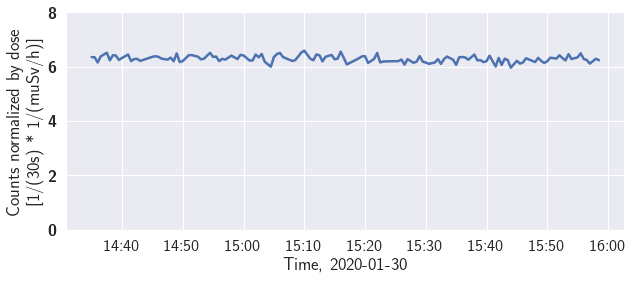

In [104]:
ref_counts_norm_no_lead = data_reference_s_rs['sum_counts']/data_dose_s_rs['dose_corrected']
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=ref_counts_norm_no_lead.index, y=ref_counts_norm_no_lead, ax=ax)

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set(yscale="log")
ax.set_ylabel('Counts normalized by dose \n [1/(30s) * 1/(muSv/h)]')
ax.set_xlabel(f'Time, {DAY}')
plt.ylim(0,8)

## Normalize also by beam power

In [105]:
data_hv_s_rs['beam_power'] = data_hv_s_rs['HV_voltage'] * data_hv_s_rs['HV_current']
ref_counts_norm_beam_no_lead = ref_counts_norm_no_lead/data_hv_s_rs['beam_power']

(0, 0.125)

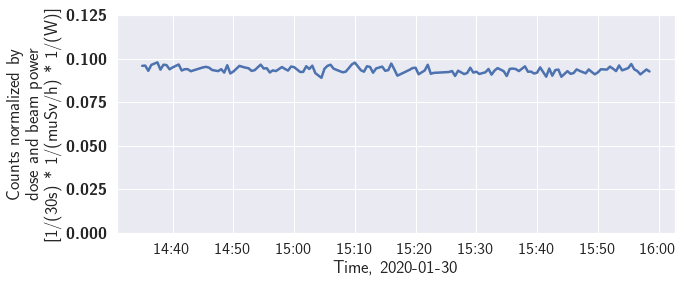

In [106]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=ref_counts_norm_beam_no_lead.index, y=ref_counts_norm_beam_no_lead, ax=ax)

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set(yscale="log")
ax.set_ylabel('Counts normalized by \n dose and beam power \n [1/(30s) * 1/(muSv/h) * 1/(W)]')
ax.set_xlabel(f'Time, {DAY}')
plt.ylim(0,0.125)

## Normalize by high voltage

(0, 0.1)

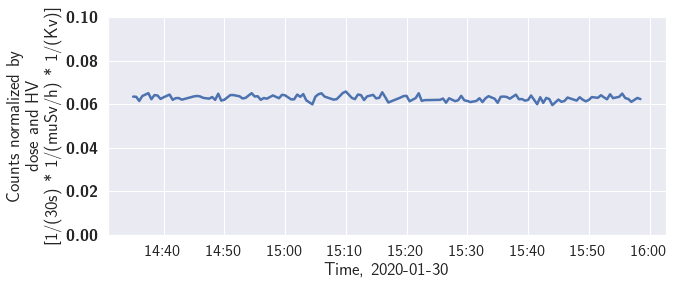

In [107]:
ref_counts_norm_HV_no_lead = ref_counts_norm_no_lead/data_hv_s_rs['HV_voltage']
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=ref_counts_norm_HV_no_lead.index, y=ref_counts_norm_HV_no_lead, ax=ax)

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set(yscale="log")
ax.set_ylabel('Counts normalized by \n dose and HV \n [1/(30s) * 1/(muSv/h) * 1/(Kv)]')
ax.set_xlabel(f'Time, {DAY}')
plt.ylim(0,0.1)

# Lead around the detectors

# From 17:54 until 19:30


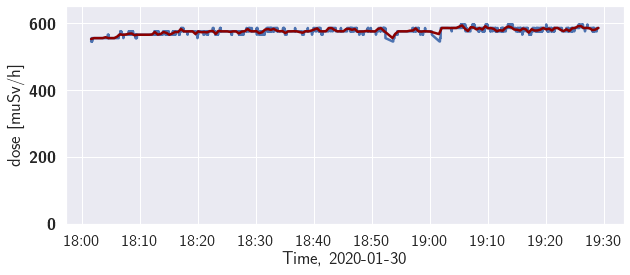

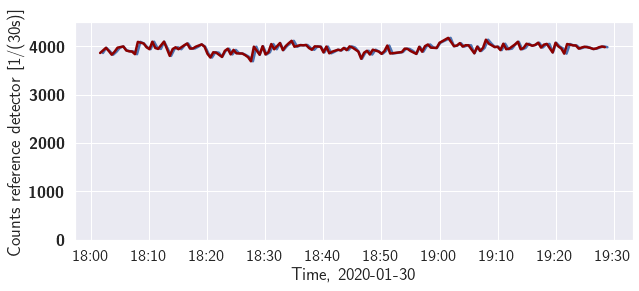

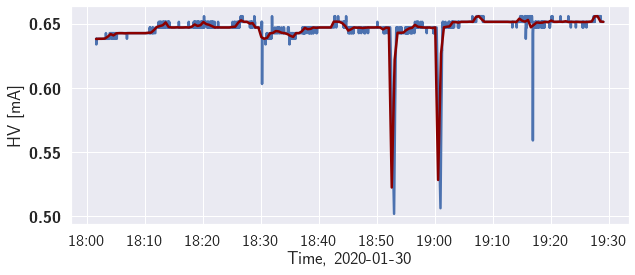

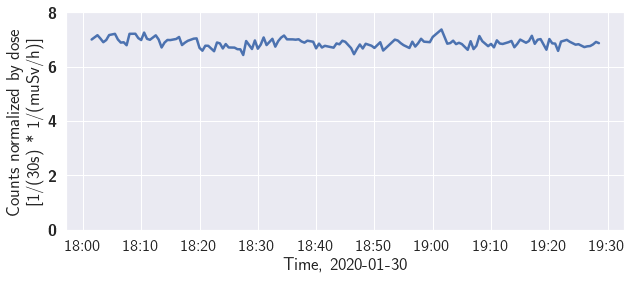

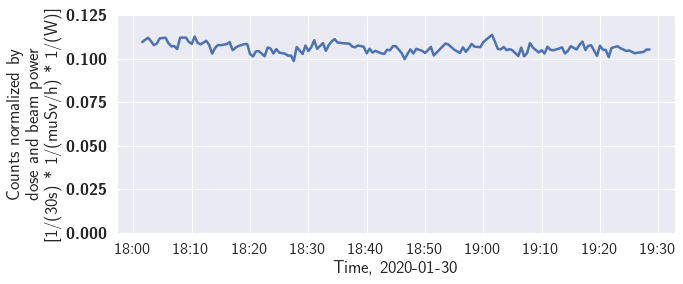

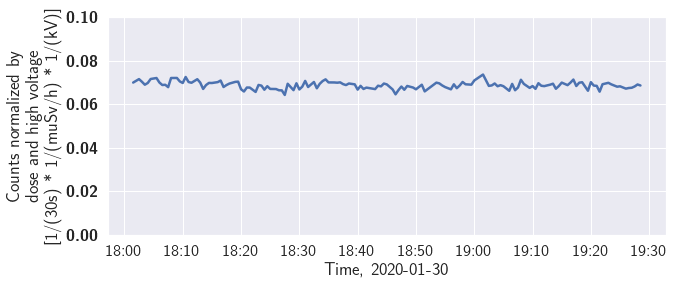

In [108]:
start = '2020-01-30 18:01:30'
end = '2020-01-30 19:29:00'

data_hv_s = data_hv.loc[start:end, :]
data_dose_s = data_dose.loc[start:end, :]
data_pressure_s = data_pressure.loc[start:end, :]
data_reference_s = data_reference_full.loc[start:end, :]
data_microwave_frequency_s = data_microwave_frequency_full.loc[start:end, :]
data_microwave_power_s = data_microwave_power_full.loc[start:end, :]

# remove outliers
data_dose_s = data_dose_s[data_dose_s['dose_corrected'] > 540]
data_reference_s = data_reference_s[data_reference_s['sum_counts'] > 3000]
data_hv_s = data_hv_s[data_hv_s['HV_current'] > 0.5]

# resample the 30 s
data_dose_s_rs = resample_30_seconds(data_dose_s, ['dose_corrected'], start, end)
data_dose_s_rs.index = data_dose_s_rs.index.rename('time')

data_reference_s_rs = resample_30_seconds(data_reference_s, ['sum_counts'], start, end)
data_reference_s_rs.index = data_reference_s_rs.index.rename('time')

data_hv_s_rs = resample_30_seconds(data_hv_s, ['HV_voltage', 'HV_current',], start, end)
data_hv_s_rs.index = data_hv_s_rs.index.rename('time')


fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_dose_s.index, y='dose_corrected', data=data_dose_s, ax=ax)
sns.lineplot(x=data_dose_s_rs.index, y='dose_corrected', data=data_dose_s_rs, ax=ax, color='darkred')
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set(yscale="log")
ax.set_ylabel('dose [muSv/h]')
ax.set_xlabel(f'Time, {DAY}')
plt.ylim(0,650)
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_reference_s.index, y='sum_counts', data=data_reference_s, ax=ax)
sns.lineplot(x=data_reference_s_rs.index, y='sum_counts', data=data_reference_s_rs, ax=ax, color='darkred')
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set(yscale="log")
ax.set_ylabel('Counts reference detector [1/(30s)]')
ax.set_xlabel(f'Time, {DAY}')
plt.ylim(0,4500)
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv_s.index, y='HV_current', data=data_hv_s, ax=ax)
sns.lineplot(x=data_hv_s_rs.index, y='HV_current', data=data_hv_s_rs, ax=ax, color='darkred')
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set(yscale="log")
ax.set_ylabel('HV [mA]')
ax.set_xlabel(f'Time, {DAY}')

data_reference_s_rs_lead = data_reference_s_rs['sum_counts']

ref_counts_norm_lead = data_reference_s_rs['sum_counts']/data_dose_s_rs['dose_corrected']
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=ref_counts_norm_lead.index, y=ref_counts_norm_lead, ax=ax)

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set(yscale="log")
ax.set_ylabel('Counts normalized by dose \n [1/(30s) * 1/(muSv/h)]')
ax.set_xlabel(f'Time, {DAY}')
plt.ylim(0,8)
plt.show()

data_hv_s_rs['beam_power'] = data_hv_s_rs['HV_voltage'] * data_hv_s_rs['HV_current']
ref_counts_norm_beam_lead = ref_counts_norm_lead/data_hv_s_rs['beam_power']

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=ref_counts_norm_beam_lead.index, y=ref_counts_norm_beam_lead, ax=ax)

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set(yscale="log")
ax.set_ylabel('Counts normalized by \n dose and beam power \n [1/(30s) * 1/(muSv/h) * 1/(W)]')
ax.set_xlabel(f'Time, {DAY}')
plt.ylim(0,0.125)
plt.show()


ref_counts_norm_HV_lead = ref_counts_norm_lead/data_hv_s_rs['HV_voltage']

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=ref_counts_norm_HV_lead.index, y=ref_counts_norm_HV_lead, ax=ax)

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set(yscale="log")
ax.set_ylabel('Counts normalized by \n dose and high voltage \n [1/(30s) * 1/(muSv/h) * 1/(kV)]')
ax.set_xlabel(f'Time, {DAY}')
plt.ylim(0,0.1)
plt.show()

## Plot both

In [109]:
ref_counts_norm_HV_lead = ref_counts_norm_HV_lead.reset_index(drop=True)
ref_counts_norm_HV_no_lead = ref_counts_norm_HV_no_lead.reset_index(drop=True)
ref_counts_norm_lead = ref_counts_norm_lead.reset_index(drop=True)
ref_counts_norm_no_lead = ref_counts_norm_no_lead.reset_index(drop=True)
ref_counts_norm_beam_lead = ref_counts_norm_beam_lead.reset_index(drop=True)
ref_counts_norm_beam_no_lead = ref_counts_norm_beam_no_lead.reset_index(drop=True)


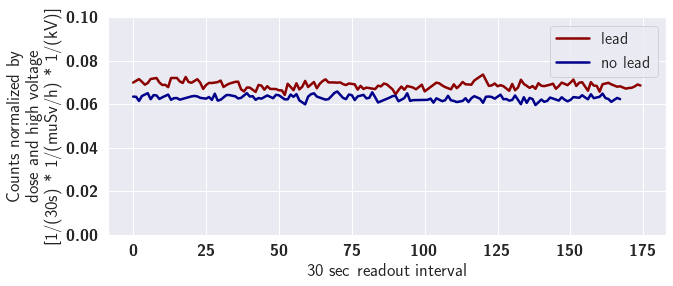

In [110]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=ref_counts_norm_HV_lead.index, y=ref_counts_norm_HV_lead, ax=ax, color='darkred', label="lead")
sns.lineplot(x=ref_counts_norm_HV_no_lead.index, y=ref_counts_norm_HV_no_lead, ax=ax, color='darkblue', label="no lead")

# ax.set(yscale="log")
ax.set_ylabel('Counts normalized by \n dose and high voltage \n [1/(30s) * 1/(muSv/h) * 1/(kV)]')
ax.set_xlabel(f'30 sec readout interval')
plt.ylim(0,0.1)
plt.show()

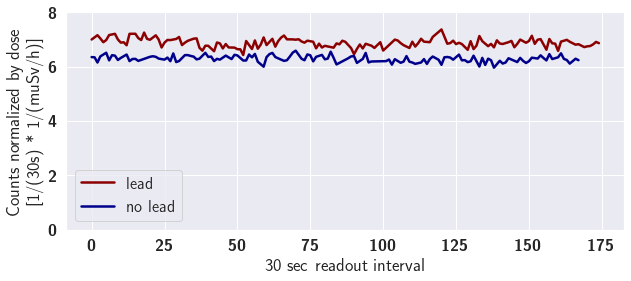

In [111]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=ref_counts_norm_lead.index, y=ref_counts_norm_lead, ax=ax, color='darkred', label="lead")
sns.lineplot(x=ref_counts_norm_no_lead.index, y=ref_counts_norm_no_lead, ax=ax, color='darkblue', label="no lead")

# ax.set(yscale="log")
ax.set_ylabel('Counts normalized by dose \n [1/(30s) * 1/(muSv/h)]')
ax.set_xlabel(f'30 sec readout interval')
plt.ylim(0,8)
plt.show()

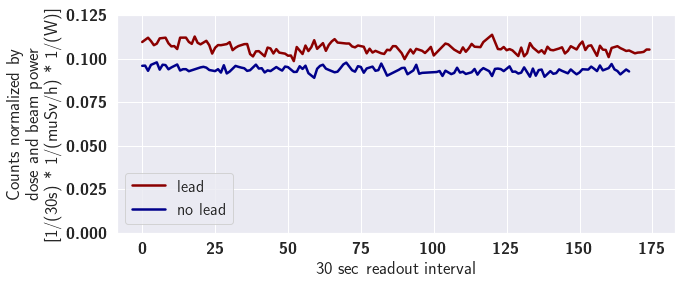

In [112]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

sns.lineplot(x=ref_counts_norm_beam_lead.index, y=ref_counts_norm_beam_lead, ax=ax, color='darkred', label="lead")
sns.lineplot(x=ref_counts_norm_beam_no_lead.index, y=ref_counts_norm_beam_no_lead, ax=ax, color='darkblue', label="no lead")

# ax.set(yscale="log")
ax.set_ylabel('Counts normalized by \n dose and beam power \n [1/(30s) * 1/(muSv/h) * 1/(W)]')
ax.set_xlabel(f'30 sec readout interval')

plt.ylim(0,0.125)
plt.show()

# Check the emitting spot size detector

In [113]:
# path to the file that contains the detector data
# from 13:30 until 18:40
fname_0 = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-01-30.EmittingSpot.Leadshield/2020-01-30_readout - Copy.csv'
data_ess_0 = pd.read_csv(fname_0, index_col=0)
data_ess_0['time'] = pd.to_datetime(data_ess_0['time'])
data_ess_0.set_index('time', inplace=True)
# from 18:40 until the next day morning
fname = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-01-30.EmittingSpot.Leadshield/2020-01-31_readout.csv'
data_ess = pd.read_csv(fname, index_col=0)
data_ess['time'] = pd.to_datetime(data_ess['time'])
data_ess.set_index('time', inplace=True)
data_ess = data_ess_0.append(data_ess)
print(data_ess.describe())
print(data_ess.info())
data_ess

       readtime        value
count    2110.0  2110.000000
mean    30192.0    69.123223
std         0.0   157.563694
min     30192.0     0.000000
25%     30192.0     2.000000
50%     30192.0     3.000000
75%     30192.0     5.000000
max     30192.0   658.000000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2110 entries, 2020-01-30 13:36:33.120836 to 2020-01-31 07:40:25.190357
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   readtime  2110 non-null   float64
 1   value     2110 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 49.5 KB
None


,readtime,value
time,,
2020-01-30 13:36:33.120836,30192.0,5
2020-01-30 13:37:03.777126,30192.0,1
2020-01-30 13:37:34.355719,30192.0,1
2020-01-30 13:38:05.028373,30192.0,2
2020-01-30 13:38:35.607365,30192.0,3
...,...,...
2020-01-31 07:38:22.859313,30192.0,0
2020-01-31 07:38:53.452960,30192.0,2
2020-01-31 07:39:24.031308,30192.0,3


In [114]:
# plot only when the measurement was performed with and without lead
start = "2020-01-30 13:30:00"
end = "2020-01-30 19:50:00"
data_ess_s = data_ess.loc[start:end, :]

# resample the 30 s
data_ess_s_rs = resample_30_seconds(data_ess_s, ['value'], start, end)
data_ess_s_rs.index = data_ess_s_rs.index.rename('time')
data_ess_s_rs

,value
time,
2020-01-30 13:30:00,NaN
2020-01-30 13:30:30,NaN
2020-01-30 13:31:00,NaN
2020-01-30 13:31:30,NaN
2020-01-30 13:32:00,NaN
...,...
2020-01-30 19:48:00,2.0
2020-01-30 19:48:30,4.0
2020-01-30 19:49:00,0.0


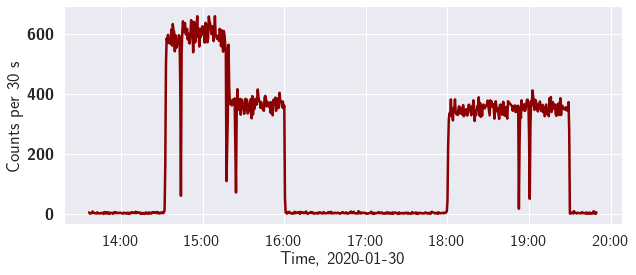

In [115]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_ess_s_rs.index, y='value', data=data_ess_s_rs, ax=ax, color='darkred')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set(yscale="log")
ax.set_ylabel('Counts per 30 s')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

## Divide in lead and no lead split

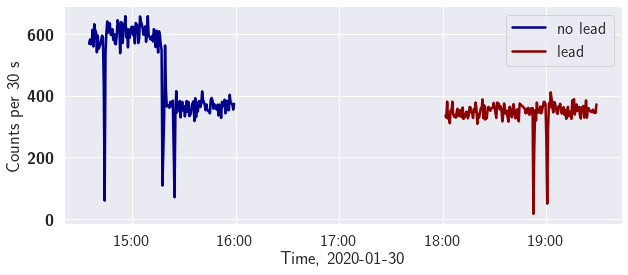

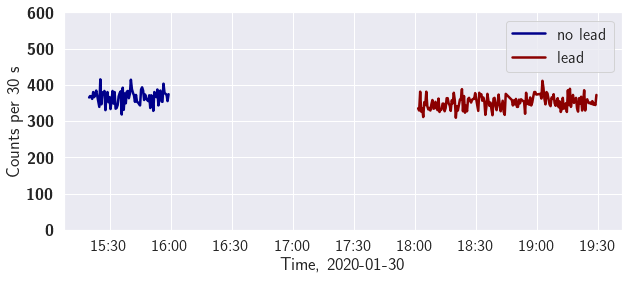

In [116]:
# no lead
start = '2020-01-30 14:35:00'
end = '2020-01-30 15:59:00'
data_ess_s_rs_no_lead = data_ess_s_rs.loc[start:end,:]
# lead
start = '2020-01-30 18:01:30'
end = '2020-01-30 19:29:00'
data_ess_s_rs_lead = data_ess_s_rs.loc[start:end,:]

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_ess_s_rs_no_lead.index, y='value', data=data_ess_s_rs_no_lead, ax=ax, color='darkblue', label='no lead')
sns.lineplot(x=data_ess_s_rs_lead.index, y='value', data=data_ess_s_rs_lead, ax=ax, color='darkred', label='lead')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set(yscale="log")
ax.set_ylabel('Counts per 30 s')
ax.set_xlabel(f'Time, {DAY}')
plt.show()


# select from no lead only when the tungsten was inserted
# no lead
start = '2020-01-30 15:20:00'
end = '2020-01-30 15:59:00'
data_ess_s_rs_no_lead = data_ess_s_rs.loc[start:end,:]

# remove breakdown values
data_ess_s_rs_no_lead = data_ess_s_rs_no_lead[data_ess_s_rs_no_lead['value'] > 300]
data_ess_s_rs_lead = data_ess_s_rs_lead[data_ess_s_rs_lead['value'] > 300]

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_ess_s_rs_no_lead.index, y='value', data=data_ess_s_rs_no_lead, ax=ax, color='darkblue', label='no lead')
sns.lineplot(x=data_ess_s_rs_lead.index, y='value', data=data_ess_s_rs_lead, ax=ax, color='darkred', label='lead')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set(yscale="log")
ax.set_ylabel('Counts per 30 s')
ax.set_xlabel(f'Time, {DAY}')
plt.ylim(0, 600)
plt.show()


## Normalize with the reference detector counts

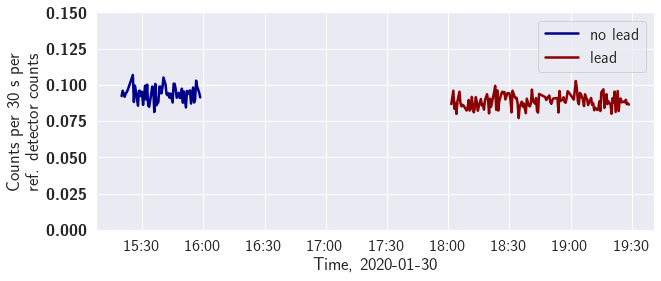

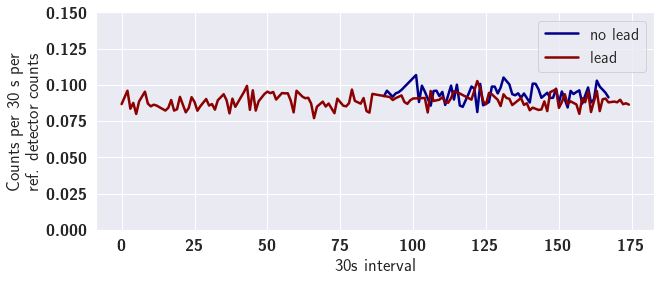

Mean, std in normed counts in the detector WITHOUT lead: 0.09397116716508827, 0.005323346509571209
Mean, std in normed counts in the detector WITH lead: 0.08851789274028586, 0.004751912368645959


In [117]:
data_ess_s_rs_no_lead_norm = data_ess_s_rs_no_lead['value']/data_reference_s_rs_no_lead['sum_counts']
data_ess_s_rs_lead_norm = data_ess_s_rs_lead['value']/data_reference_s_rs_lead

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_ess_s_rs_no_lead_norm.index, y=data_ess_s_rs_no_lead_norm, ax=ax, color='darkblue', label='no lead')
sns.lineplot(x=data_ess_s_rs_lead_norm.index, y=data_ess_s_rs_lead_norm, ax=ax, color='darkred', label='lead')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set(yscale="log")
ax.set_ylabel('Counts per 30 s per \n ref. detector counts')
ax.set_xlabel(f'Time, {DAY}')
plt.ylim(0, 0.15)
plt.show()

data_ess_s_rs_no_lead_norm.reset_index(drop=True, inplace=True)
data_ess_s_rs_lead_norm.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_ess_s_rs_no_lead_norm.index, y=data_ess_s_rs_no_lead_norm, ax=ax, color='darkblue', label='no lead')
sns.lineplot(x=data_ess_s_rs_lead_norm.index, y=data_ess_s_rs_lead_norm, ax=ax, color='darkred', label='lead')

# ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set(yscale="log")
ax.set_ylabel('Counts per 30 s per \n ref. detector counts')
ax.set_xlabel(f'30s interval')
plt.ylim(0, 0.15)
plt.show()

print(f"Mean, std in normed counts in the detector WITHOUT lead: {data_ess_s_rs_no_lead_norm.mean()}, {data_ess_s_rs_no_lead_norm.std()}")
print(f"Mean, std in normed counts in the detector WITH lead: {data_ess_s_rs_lead_norm.mean()}, {data_ess_s_rs_lead_norm.std()}")

In [118]:
# Combine reference detector counts into one dataframe
data_ess_s_rs_no_lead_norm = pd.DataFrame(data_ess_s_rs_no_lead_norm)
data_ess_s_rs_lead_norm = pd.DataFrame(data_ess_s_rs_lead_norm)
data_ess_s_rs_no_lead_norm['label'] = 'no lead'
data_ess_s_rs_lead_norm['label'] = 'lead'

data_ess_s_rs_norm_combined = data_ess_s_rs_no_lead_norm.append(data_ess_s_rs_lead_norm).reset_index(drop=True)
data_ess_s_rs_norm_combined

,0,label
0,NaN,no lead
1,NaN,no lead
2,NaN,no lead
3,NaN,no lead
4,NaN,no lead
...,...,...
340,0.089692,lead
341,0.086596,lead
342,0.087250,lead
343,0.086324,lead


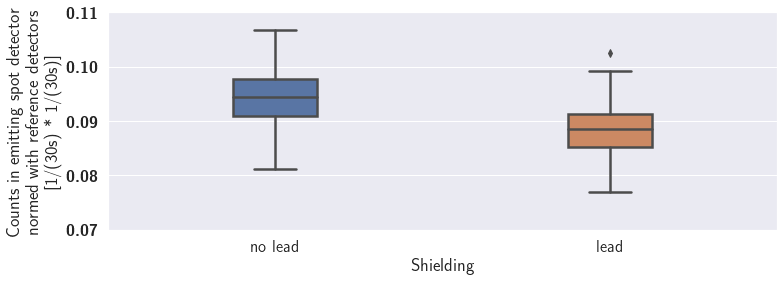

In [119]:
fig, ax = plt.subplots(figsize=(12,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.boxplot(x='label', y=0, data=data_ess_s_rs_norm_combined, ax=ax, width=0.25)


# plt.title('Reference detectors')
# ax.set(yscale="log")
ax.set_ylabel('Counts in emitting spot detector \n normed with reference detectors \n [1/(30s) * 1/(30s)]')
ax.set_xlabel(f'Shielding')
plt.ylim(0.07, 0.11)
plt.show()

In [122]:
data_ess_s_rs_norm_combined.to_csv('/Users/hkromer/02_PhD/04_Publiations/08.Defense/Figures/ess_countrate_suppression_proof.data')
data_ess_s_rs_norm_combined.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       202 non-null    float64
 1   label   345 non-null    object 
dtypes: float64(1), object(1)
memory usage: 5.5+ KB


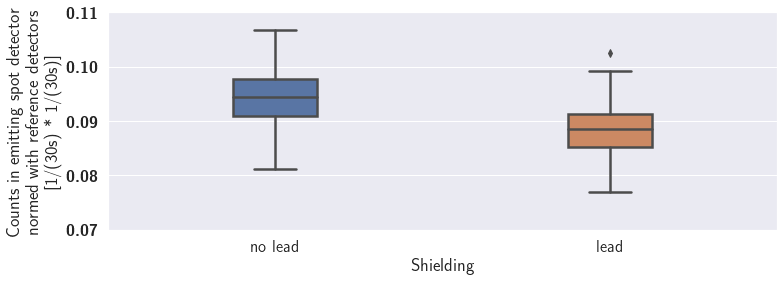

In [121]:
fig, ax = plt.subplots(figsize=(12,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.boxplot(x='label', y=0, data=data_ess_s_rs_norm_combined, ax=ax, width=0.25)


# plt.title('Reference detectors')
# ax.set(yscale="log")
ax.set_ylabel('Counts in emitting spot detector \n normed with reference detectors \n [1/(30s) * 1/(30s)]')
ax.set_xlabel(f'Shielding')
plt.ylim(0.07, 0.11)
plt.show()

## Plot for defense

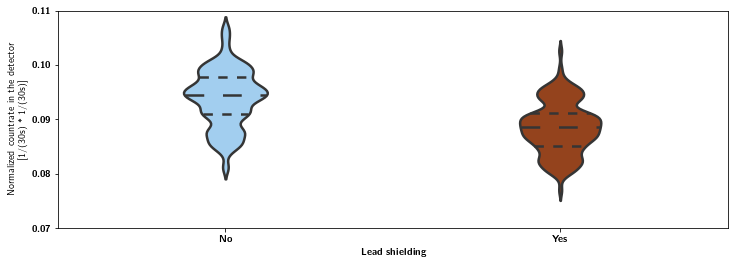

In [72]:
# sns.reset_orig()
# import os, matplotlib
# os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
# plt.rc('text', usetex=True)
# plt.rc('font', weight='bold')
# matplotlib.rcParams['mathtext.fontset'] = 'custom'
# matplotlib.rcParams['mathtext.rm'] = 'Arial'
# matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
# matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
# matplotlib.rcParams['mathtext.tt'] = 'Arial'
# matplotlib.rcParams['mathtext.cal'] = 'Arial'
# matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


# fig, ax = plt.subplots(figsize=(12,4))
# fs = 20
# # Make a dictionary with one specific color per group:
# my_pal = {"no lead": "#95d0fc", "lead": "#a83c09"}

# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
# sns.violinplot(x='label', y=0, data=data_ess_s_rs_norm_combined, ax=ax, width=0.25, inner='quartile', bw=0.2, palette=my_pal)


# # plt.title('Reference detectors')
# # ax.set(yscale="log")
# ax.set_ylabel('Normalized countrate in the detector \n [1/(30s) * 1/(30s)]')
# ax.set_xlabel(r'\textbf{Lead shielding}')
# plt.ylim(0.07, 0.11)
# plt.xticks([0, 1], [r'\textbf{No}', r'\textbf{Yes}'])
# plt.show()

# Attenuation of 100 keV x-rays in stainless steel

In [52]:
# approximated by iron, 0.1 MeV
MU_RHO = 3.717e-1 # cm2/g
# density
RHO = 7.874 # g/cm³

# attenuation coefficient
sigma = MU_RHO * RHO # 1/cm

# lambert beer attenuation, .. mm iron
D = 0.3 # cm, thickness of chamber
I_over_I0 = np.exp(-sigma*D)
print(f'Fraction of beam left after {D} cm iron: {1-I_over_I0:.2f}')
# lambert beer attenuation, .. mm iron
D = 0.5 # cm, thickness of chamber
I_over_I0 = np.exp(-sigma*D)
print(f'Fraction of beam left after {D} cm iron: {1-I_over_I0:.2f}')

Fraction of beam left after 0.3 cm iron: 0.58
Fraction of beam left after 0.5 cm iron: 0.77
